# Collect Tweets into MongoDB

## Install Python libraries

You may need to restart your Jupyter Notebook instance after installed those libraries.

In [14]:
!pip install pymongo

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [15]:
!pip install pymongo[srv]

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [16]:
!pip install dnspython

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [17]:
!pip install tweepy

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [18]:
!pip install twitter

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


## Import Python libraries

In [19]:
import pymongo
from pymongo import MongoClient
import json
import tweepy
import twitter
from pprint import pprint
import configparser
import pandas as pd

##  Load the Authorization Info

Save database connection info and API Keys in a config.ini file and use the configparse to load the authorization info. 

In [20]:
config = configparser.ConfigParser()
config.read('config.ini')

CONSUMER_KEY      = config['mytwitter']['api_key']
CONSUMER_SECRET   = config['mytwitter']['api_secrete']
OAUTH_TOKEN       = config['mytwitter']['access_token']
OATH_TOKEN_SECRET = config['mytwitter']['access_secrete']

mongod_connect = config['mymongo']['connection']

## Connect to the MongoDB Cluster

In [21]:
client = MongoClient(mongod_connect)
db = client.gp17 # use or create a database named demo
tweet_collection = db.lab11 #use or create a collection named tweet_collection
tweet_collection.create_index([("id", pymongo.ASCENDING)],unique = True) # make sure the collected tweets are unique

'id_1'

## Use the Streaming API to Collect Tweets

Authorize the Stream API 

In [22]:
stream_auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
stream_auth.set_access_token(OAUTH_TOKEN, OATH_TOKEN_SECRET)

strem_api = tweepy.API(stream_auth)

Define the query for the Stream API

In [23]:
track = ['election'] # define the keywords, tweets contain election

locations = [-78.9326449,38.4150904,-78.8816972,38.4450731] #defin the location, in Harrisonburg, VA

The collected tweets will contain 'election' <span style="color:red;font-weight:bold"> OR </span> are located in Harrisonburg, VA

In [ ]:
class MyStreamListener(tweepy.StreamListener):
    def on_status(self, status):
        print (status.id_str)
        try:
            tweet_collection.insert_one(status._json)
        except:
            pass
  
    def on_error(self, status_code):
        if status_code == 420:
            #returning False in on_data disconnects the stream
            return False
myStreamListener = MyStreamListener()
myStream = tweepy.Stream(auth = strem_api.auth, listener=myStreamListener)
myStream.filter(track=track)#  (locations = locations)   #Use either track or locations

## Use the REST API to Collect Tweets

Authorize the REST API 

In [24]:
rest_auth = twitter.oauth.OAuth(OAUTH_TOKEN,OATH_TOKEN_SECRET,CONSUMER_KEY,CONSUMER_SECRET)
rest_api = twitter.Twitter(auth=rest_auth)

Define the query for the REST API

In [25]:
count = 100 #number of returned tweets, default and max is 100
geocode = "37.5247764, -775633011,150mi"  # defin the location, in Harrisonburg, VA
q = "covid19"                               #define the keywords, tweets contain election

The collected tweets will contain 'election' <span style="color:red;font-weight:bold"> AND </span> are located in Harrisonburg, VA

In [26]:
search_results = rest_api.search.tweets( count=count,q=q, geocode=geocode) #you can use both q and geocode
statuses = search_results["statuses"]
since_id_new = statuses[-1]['id']
for statuse in statuses:
    try:
        tweet_collection.insert_one(statuse)
        pprint(statuse['created_at'])# print the date of the collected tweets
    except:
        pass

IndexError: list index out of range

Continue fetching early tweets with the same query. 
<p><span style="color:red;font-weight:bold">YOU WILL REACH YOUR RATE LIMIT VERY FAST</span></p>

In [27]:
since_id_old = 0
while(since_id_new != since_id_old):
    since_id_old = since_id_new
    search_results = rest_api.search.tweets( count=count,q=q,
                        geocode=geocode, max_id= since_id_new)
    statuses = search_results["statuses"]
    since_id_new = statuses[-1]['id']
    for statuse in statuses:
        try:
            tweet_collection.insert_one(statuse)
            pprint(statuse['created_at']) # print the date of the collected tweets
        except:
            pass

NameError: name 'since_id_new' is not defined

## View the Collected Tweets

Print the number of tweets and unique twitter users

In [28]:
print(tweet_collection.estimated_document_count())# number of tweets collected

user_cursor = tweet_collection.distinct("user.id")
print (len(user_cursor)) # number of unique Twitter users 

0
0


Create a text index and print the Tweets containing specific keywords. 

In [29]:
tweet_collection.create_index([("text", pymongo.TEXT)], name='text_index', default_language='english') # create a text index


'text_index'

Create a cursor to query tweets with the created index

In [30]:
tweet_cursor = tweet_collection.find({"$text": {"$search": "vote"}}) # return tweets contain vote

Use pprint to display tweets

In [31]:

for document in tweet_cursor[0:10]: # display the first 10 tweets from the query
    try:
        print ('----')
#         pprint (document) # use pprint to print the entire tweet document
   
        print ('name:', document["user"]["name"]) # user name
        print ('text:', document["text"])         # tweets
    except:
        print ("***error in encoding")
        pass

In [32]:
tweet_cursor = tweet_collection.find({"$text": {"$search": "vote"}}) # return tweets contain vote

Use pandas to display tweets

In [33]:
tweet_df = pd.DataFrame(list(tweet_cursor ))
tweet_df[:10] #display the first 10 tweets

""


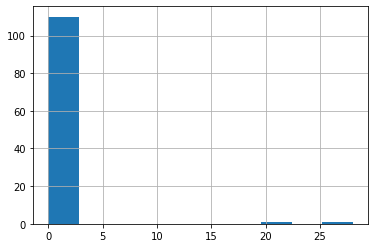

In [14]:
tweet_df["favorite_count"].hist() # create a histogram show the favorite count